# Introduction to Theory of Football Formations
#### Final Project for Econ 323

Student: Bruno Belevan
Last Update: April 29th, 2020

## Introduction

Football is a sport that due to its complex dynamics, it is very hard to predict. This project aims to evaluate the extent on which formations (which are posted pre-match) have a predictibility significance in the outcome of certain match variables (passes completed, goals scored, and goals conceded). 

This project is a precursor of my possible future undergraduate economics thesis, that will have the aim to use game theory to predict match outcomes. Here we are going to abstract football formations to its simpler form, and just create the groundwork for future more complex models. 

The project counts with 5 main sections:
- **Scapper**: creating a data set from data of the official premier league website

- **NetworkX**: Analysing basic the basic connections between player positioning

- **Data Arrangement**: Combining Data Sets and NetworkX predictions

- **Descriptive Analysis**: Looking at the Distribution of Formations

- **Predictive Analysis**:
    - Regressions
    - Machine Learning
    
It is important to clarify what we mean by football formation theory. Here, we are going to simplify and breakdown the game as much as possible. As already mentioned, football can be simplified by the following parameters: you choose a formation for 10 players, the playes pass the ball, score goals, and try to not concede goals. During a match, we are going to assume that the formation does not change at least one of the 10 players gets a red card (leave their position for the rest of the match). With NetworkX, we are going to recreate each player's position on the pitch, and create a network (nodes and edges) that represent the range of passing possibilities each player has. Then, we can compare the ranges of passes each time has, and compare if the number of edges/connections influence outcomes as total number of passes, goals scored, and goals conceded.

Here are the following packages used in this project. Please note that selenium is not imported as other packages. Refer to the ReadMe document to download it.

In [312]:
import time
import pandas as pd
import requests
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import linear_model

from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

## Scrapper

##### Obtaining the MatchIDs of a Given Season 

Lets start by analysing the website of the Premier League (https://www.premierleague.com/home). Here we want to go to results. To do this, lets start by selecting the right URL which is 'https://www.premierleague.com/results?team=FIRST'. Now we are sure we have choosen the right division.

Second step is to 'Filter' our desired season. We notice that all matches of that season will appear by scrolling to the end of the page. Each match will count with a MatchID, that can be added to 'https://footballapi.pulselive.com/football/stats/match/' that will give us all the stadistics we need for that match. 

Therefore, our first objective is to create a bot that will give us all the matchIds for any season we command. Because the premier league website works along with requests and requires a lot of clicking, I have selected to use the package Selenium. For instructions on how to download and still Selenium please go to the ReadMe Document in the main repository. 

A key aspect to note is that there is one potential frequent change on the website: sometimes there is an advert you have to command the bot to close, and sometimes there is no advert. This advert can be closed with by clicking the X in the top right coner. I have added a try/except line to make sure the code continues if there is no ad. Take into account that the code will take longer to run if there is no ad as it will respect the wait time assigned.

**IMPORTANT:** If you are not able to install Selenium, a CSV with the dataframe is provided in the repository. More details provided in line just before NetworkX section. A section has been added were you can start running the rest of the code without Selenium.

In [13]:
# Define the URl of the Premier League Results
url = 'https://www.premierleague.com/results?team=FIRST/'

# Select Wait Time and Season. If you have a slower internet connection, you might want to increase the wait time to make sure
# selenium runs smothly
wait_time = 1
season_year = "2018/19" # Make sure to follow the string and yyyy/yy format

# Selection of Webdriver
browser = webdriver.Chrome()
browser.maximize_window()
wait = WebDriverWait(browser, 30)

# Open Browser
browser.get(url)

# Accept Cookies
xpath_cookies = '//div[@class="btn-primary cookies-notice-accept"]/span'
cookies = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_cookies)))
time.sleep(wait_time)
cookies.click()

# Close Ad
try:
    xpath_ad = '//a[@id="advertClose"]'
    ad = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_ad)))
    time.sleep(wait_time)
    ad.click()
except:
    pass

# Open Season Tab
xpath_season = '//div[@data-dropdown-current="compSeasons"]'
season = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_season)))
time.sleep(wait_time)
season.click()

# Select Season
xpath_year = f'//li[@data-option-name="{season_year}"]'
year = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_year)))
time.sleep(5)
year.click()

# Scroll to end to get all data (Repeated twice to make sure all data is obtained)
time.sleep(wait_time)
browser.find_element_by_xpath('//body').send_keys(Keys.CONTROL+Keys.END)
time.sleep(wait_time)
browser.find_element_by_xpath('//body').send_keys(Keys.CONTROL+Keys.END)

# Collecting all Match Ids from body of webpage
matchids = []
xpath_matchid = "//div[contains(@class,'active')]/div/section[@class='fixtures']/div/ul/li/div[@class]"
matchids = wait.until(EC.presence_of_all_elements_located((By.XPATH, xpath_matchid)))
while len(matchids) < 380:
    time.sleep(wait_time)
    browser.find_element_by_xpath('//body').send_keys(Keys.CONTROL+Keys.END)
    matchids = wait.until(EC.presence_of_all_elements_located((By.XPATH, xpath_matchid)))
    if len(matchids) == 380:
        break 
    elif len(matchids) > 380:
        print("Warning. This season had more than 380 matches.")

# Extract only the ID number of the entire string
ids = []
for id in matchids:
    ids.append(id.get_attribute("data-matchid"))
    
list_ids = pd.DataFrame(ids)  

# Close Browser
browser.close()
browser.quit()

list_ids.rename(columns={(0):"ID"})

,ID
0,38678
1,38679
2,38680
3,38681
4,38682
...,...
375,38310
376,38311
377,38316
378,38317


As you can see, not all matchids are in order. With this method we are going to be able to recreate this experiment with any season that we wish. In this way, if by any chance there are minimal changes in the number of ids for any reason, our code will remain valid. Now, of course, we cannot use this same method (clicking) for collecting the rest of our data because it would take too long. 

##### Using the IDs to obtain Match Data by Request

Now comes the actual data scrapping of the match statistics. Here we will use the package request to be able to obtain the data. Please note that this request might take around 3 minutes.

In [14]:
def club_id(info):
    """
    Obatins the club's (team) unique ID, which are mantained throughout all seasons.
    
    The input infor is jsonloads of our request.
    """
    id_home = info["entity"]["teams"][0]["team"]["id"]
    id_away = info["entity"]["teams"][1]["team"]["id"]
    return id_home, id_away

def find_stat (home_away, stat_name):
    """
    Obatins the any statistic we want inside the request.
    
    The inputs are if we want the info for the home or away team (0 = home), and the name of 
    the statistic in the request text. 
    """
    data_format = info["data"][str(club_id(info)[home_away])]['M']
    for num, stat in enumerate(data_format):
        if data_format[num]["name"] == stat_name:
            value = data_format[num]["value"]
            return data_format[num]["value"]
        
def club_name (home_away):
    """
    Obatins the club's (team) unique ID, which are mantained throughout all seasons.
    
    The input represent if the info for the home or away team (0 = home)
    """
    abbr_home = info["entity"]["teams"][0]["team"]["club"]["shortName"]
    abbr_away = info["entity"]["teams"][1]["team"]["club"]["shortName"]
    return abbr_home, abbr_away

# Headers Required by the Request
headers = {
    'authority': 'footballapi.pulselive.com',
    'sec-ch-ua': '^\\^',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.72 Safari/537.36',
    'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'accept': '*/*',
    'origin': 'https://www.premierleague.com',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://www.premierleague.com/',
    'accept-language': 'es-ES,es;q=0.9,en;q=0.8',
    'if-none-match': 'W/^\\^0bc0822daddc052089673dacc1542f161^\\^',
}

# Creating empty lists to compile the data

# General Info
club_id_home = []
club_id_away = []
club_name_home = []
club_name_away = []
            
# Data
formation_home = []
formation_away = []
total_pass_home = []
total_pass_away = []
goals_scored_home = []
goals_scored_away = []
goals_conceded_home = []
goals_conceded_away = []
red_card_home = []
rec_card_away = []

# Request for All Match IDs. 1st Loop goes through all ids, and second loop through home and away teams. 
for num, id in enumerate(list_ids[0]):
    response = requests.get('https://footballapi.pulselive.com/football/stats/match/'+str(id), headers=headers)
    #print(num)
    info = json.loads(response.text)   
    
    for i in list(range(2)):
        stat = find_stat(i, "formation_used")
        if i == 0:
            formation_home.append(stat)
        else:
            formation_away.append(stat)
    
    for i in list(range(2)):
        stat = find_stat(i, "total_pass")
        if i == 0:
            total_pass_home.append(stat)
        else:
            total_pass_away.append(stat)
            
    for i in list(range(2)):
        stat = find_stat(i, "goals")
        if i == 0:
            goals_scored_home.append(stat)    
        else:
            goals_scored_away.append(stat)
            
    for i in list(range(2)):
        stat = find_stat(i, "goals_conceded")
        if i == 0:
            goals_conceded_home.append(stat)
        else:
            goals_conceded_away.append(stat)
            
    for i in list(range(2)):
        stat = find_stat(i, "total_red_card")
        if i == 0:
            red_card_home.append(stat)
        else:
            rec_card_away.append(stat)
            
    for i in list(range(2)):
        if i == 0:
            club_name_home.append(club_name(info)[i])
        else:
            club_name_away.append(club_name(info)[i])
            
    for i in list(range(2)):
        if i == 0:
            club_id_home.append(club_id(info)[i])
        else:
            club_id_away.append(club_id(info)[i])
            
    #print(num) #Uncomment this print if you want to make sure the code is running smothly. It counts until 379. 

In [15]:
# Rename Variable
d = {"Match ID": ids,
     "Home ID": club_id_home,
     "Away ID": club_id_away,
     "Home Name": club_name_home,
     "Away Name": club_name_away,
     "Home Formation": formation_home, 
     "Away Formation": formation_away,
     "Home Goals": goals_scored_home, 
     "Away Goals": goals_scored_away,
     "Home Goals Conceded": goals_conceded_home,
     "Away Goals Conceded": goals_conceded_away,
     "Home Passes": total_pass_home,
     "Away Passes": total_pass_away,
     "Red Cards Home": red_card_home,
     "Red Cards Away": rec_card_away
    }
data_df = pd.DataFrame(data=d)

data_df

,Match ID,Home ID,Away ID,Home Name,Away Name,Home Formation,Away Formation,Home Goals,Away Goals,Home Goals Conceded,Away Goals Conceded,Home Passes,Away Passes,Red Cards Home,Red Cards Away
0,38678,131,11,Brighton,Man City,451.0,4411.0,1.0,4.0,4.0,1.0,245.0,796.0,NaN,NaN
1,38679,43,1,Burnley,Arsenal,442.0,4231.0,1.0,3.0,3.0,1.0,341.0,533.0,NaN,NaN
2,38680,6,127,Crystal Palace,Bournemouth,442.0,4411.0,5.0,3.0,3.0,5.0,429.0,517.0,NaN,NaN
3,38681,34,23,Fulham,Newcastle,4231.0,541.0,NaN,4.0,4.0,NaN,765.0,358.0,NaN,NaN
4,38682,26,4,Leicester,Chelsea,4141.0,433.0,NaN,NaN,NaN,NaN,470.0,533.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,38310,34,6,Fulham,Crystal Palace,433.0,442.0,NaN,2.0,2.0,NaN,672.0,347.0,NaN,NaN
376,38311,159,4,Huddersfield,Chelsea,3511.0,433.0,NaN,3.0,3.0,NaN,372.0,658.0,NaN,NaN
377,38316,33,131,Watford,Brighton,4222.0,4411.0,2.0,NaN,NaN,2.0,437.0,385.0,NaN,NaN
378,38317,38,7,Wolves,Everton,343.0,4231.0,2.0,2.0,2.0,2.0,547.0,409.0,NaN,1.0


##### Positions Table of Previous Year

The reason we want to obtain the table of last season's position is so we can control later for team quality. The higher the team positioned last season, the better we can expect them to perform this season.

Again, we will start with Selenium to obtain the id of each season and obtain the data with request. Pease note that this request might take around 3 minutes.

In [16]:
# Define the URl of the Premier League Tables
url = 'https://www.premierleague.com/tables'
year_table = "2018/19" # Make sure to follow the string and yyyy/yy format

# We proceed with Selenium

tables = []

# Select Wait Time and Season. If you have a slower internet connection, you might want to increase the wait time to make sure
# selenium runs smothly
wait_time = 2
start_year = list(range(1995, 2020 + 1)) # We are going to download all tables from 1995 to today

browser = webdriver.Chrome()
browser.maximize_window()
wait = WebDriverWait(browser, 60)


browser.get(url)

# Accept Cookies
xpath_cookies = '//div[@class="btn-primary cookies-notice-accept"]/span'
cookies = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_cookies)))
time.sleep(wait_time)
cookies.click()

# Close Ad
try:
    xpath_ad = '//a[@id="advertClose"]'
    ad = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_ad)))
    time.sleep(wait_time)
    ad.click()
except:
    pass


# The following Loop enters a season and by using request donwloads the teams position that season
for year in start_year:
    season_year = str(year)
    abbr_year = str(year + 1)
    season_year = season_year + "/" + abbr_year[-2:]

    # Open Season Tab
    xpath_season = '//div[@data-dropdown-current="compSeasons"]'
    season = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_season)))
    time.sleep(wait_time)
    season.click()

    # Select Season
    xpath_year = f'//li[@data-option-name="{season_year}"]'
    year = wait.until(EC.element_to_be_clickable((By.XPATH, xpath_year)))
    time.sleep(wait_time)
    year.click()

    sleep(wait_time)
    current_url = browser.current_url
    current_url = current_url.split("=")
    current_url = current_url[2]
    idx = current_url.find("&")
    current_url = current_url[:idx]
    current_url
    
    headers = {
    'authority': 'footballapi.pulselive.com',
    'sec-ch-ua': '^\\^',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36',
    'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'accept': '*/*',
    'origin': 'https://www.premierleague.com',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://www.premierleague.com/',
    'accept-language': 'en-US,en;q=0.9',
    }

    params = (
        ('compSeasons', current_url),
        ('altIds', 'true'),
        ('detail', '2'),
        ('FOOTBALL_COMPETITION', '1'),
    )

    response = requests.get('https://footballapi.pulselive.com/football/standings', headers=headers, params=params)
    info = json.loads(response.text)  
    
    club_id = []
    name_club = []
    position_club = []

    for i in range(20): 
    # id and name
        c_id = info["tables"][0]["entries"][i]['team']['id']
        club_id.append(c_id)
        name = info["tables"][0]["entries"][i]['team']['shortName']
        name_club.append(name)
    # position
        position = info["tables"][0]["entries"][i]["position"]
        position_club.append(position)

    d = {"Year": season_year,
     "Position": position_club,
     "ID": club_id,
     "Name": name_club,
        }
    df = pd.DataFrame(data=d)
    df = df.pivot(index=["Position"], columns=["Year"])
    #display(df)
    tables.append(df)
    
# Close Browser
browser.close()
browser.quit()

final_table = pd.DataFrame()

for i in range(len(tables)):
    final_table = pd.concat([final_table, tables[i]], axis=1)
    
display(final_table)

,ID,Name,ID,Name,ID,Name,ID,Name,ID,Name,...,ID,Name,ID,Name,ID,Name,ID,Name,ID,Name
Year,1995/96,1995/96,1996/97,1996/97,1997/98,1997/98,1998/99,1998/99,1999/00,1999/00,...,2016/17,2016/17,2017/18,2017/18,2018/19,2018/19,2019/20,2019/20,2020/21,2020/21
Position,,,,,,,,,,,,,,,,,,,,,
1,12,Man Utd,12,Man Utd,1,Arsenal,12,Man Utd,12,Man Utd,...,4,Chelsea,11,Man City,11,Man City,10,Liverpool,11,Man City
2,23,Newcastle,23,Newcastle,12,Man Utd,1,Arsenal,1,Arsenal,...,21,Spurs,12,Man Utd,10,Liverpool,11,Man City,12,Man Utd
3,10,Liverpool,1,Arsenal,10,Liverpool,4,Chelsea,9,Leeds,...,11,Man City,21,Spurs,4,Chelsea,12,Man Utd,26,Leicester
4,2,Aston Villa,10,Liverpool,4,Chelsea,9,Leeds,10,Liverpool,...,10,Liverpool,10,Liverpool,21,Spurs,4,Chelsea,4,Chelsea
5,1,Arsenal,2,Aston Villa,9,Leeds,25,West Ham,4,Chelsea,...,1,Arsenal,4,Chelsea,1,Arsenal,26,Leicester,25,West Ham
6,7,Everton,4,Chelsea,3,Blackburn,2,Aston Villa,2,Aston Villa,...,12,Man Utd,1,Arsenal,12,Man Utd,21,Spurs,10,Liverpool
7,3,Blackburn,19,Sheffield Wed,2,Aston Villa,10,Liverpool,29,Sunderland,...,7,Everton,43,Burnley,38,Wolves,38,Wolves,21,Spurs
8,21,Spurs,22,Wimbledon,25,West Ham,28,Derby,26,Leicester,...,20,Southampton,7,Everton,7,Everton,1,Arsenal,7,Everton


For later in our analysis, we are going to attribute an assumed pass accuracy to different positions in the table. We are going to assumed that the better teams have better pass accuracy, divided as follows:

In [50]:
year = "2017/18" # Choose the table of the season previous to the one you are analyzing

# Choose Accuracy Assumption
up = 0.95
mid_up = 0.85
mid_low = 0.75
low = 0.65

# Create Pass Acquaracy Variable
pass_quality = []
for i in range(1, 18):
    
    if i < 6:
        value = up
    elif i > 5 and i < 11:
        value = mid_up
    elif i > 10 and i < 16:
        value = mid_low
    else:
        value = low
                
    pass_quality.append([final_table["ID"][year][i], value])
    
# Create Dataframe with new variable
pass_quality_Home = pd.DataFrame(pass_quality, columns=["Home ID", "Home Pass Quality"])
pass_quality_Away = pd.DataFrame(pass_quality, columns=["Away ID", "Away Pass Quality"])

# Merge DataFrames
# Home
complete_dataset = pd.merge(data_df, pass_quality_Home, on="Home ID", how="outer")
index_home = complete_dataset[np.isnan(complete_dataset["Home Pass Quality"])].index
complete_dataset.loc[index_home, "Home Pass Quality"] = low
# Away
complete_dataset = pd.merge(complete_dataset, pass_quality_Away, on="Away ID", how="outer")
index_home = complete_dataset[np.isnan(complete_dataset["Away Pass Quality"])].index
complete_dataset.loc[index_home, "Away Pass Quality"] = low

# Replace NaNs with Zeros
complete_dataset = complete_dataset.fillna(0)

In [41]:
# From Pandas Documentation
compression_opts = dict(method='zip',
                        archive_name='dataframe.csv')
complete_dataset.to_csv('dataframe.zip', index=False,
          compression=compression_opts)

## In Case you cannot run Selenium, Please Start Here

In [31]:
complete_dataset_download = pd.read_csv("https://raw.githubusercontent.com/brunobelevan/Football-Theory---Formations/main/dataframe.csv")
complete_dataset_download.head()

,Match ID,Home ID,Away ID,Home Name,Away Name,Home Formation,Away Formation,Home Goals,Away Goals,Home Goals Conceded,Away Goals Conceded,Home Passes,Away Passes,Red Cards Home,Red Cards Away,Home Pass Quality,Away Pass Quality
0,38678,131,11,Brighton,Man City,451.0,4411.0,1.0,4.0,4.0,1.0,245.0,796.0,0.0,0.0,0.75,0.95
1,38659,43,11,Burnley,Man City,442.0,433.0,0.0,1.0,1.0,0.0,263.0,608.0,0.0,0.0,0.85,0.95
2,38640,6,11,Crystal Palace,Man City,451.0,4231.0,1.0,3.0,3.0,1.0,274.0,721.0,0.0,0.0,0.75,0.95
3,38623,34,11,Fulham,Man City,541.0,433.0,0.0,2.0,2.0,0.0,359.0,679.0,0.0,0.0,0.65,0.95
4,38492,26,11,Leicester,Man City,433.0,433.0,2.0,1.0,1.0,2.0,320.0,613.0,0.0,1.0,0.85,0.95


## NetworkX

The next step is to create a network of range of possible passes in each formation. This is a way of ranking and categorizing the different formations. The number 4-3-3 has no meaning, and with NetworkX we are trying to putting each formation into an analysable context.

First, we are going to create different functions to be able to plot our network:

In [21]:
def split_form(formation):
    """
    Transforms a float number into a list. Serves to split the float formation format
    into lines, each represeting the total number of players per line. 
    
    The input is a float number.
    """
    form = int(formation)
    form = [int(i) for i in str(form)]
    return form


def transform_formation(formation):
    """
    When given a formation in the form of a list (each value representing the number of players per line),
    the function positions each player symmetrically on the pitch by creating a coordinate for each one. 
    
    We define the results as nodes.
    """
    pos = {} # List to compile the players' coordinates in the pitch
    k = 0    # K is used to enumerate each player

    for j in range(len(formation)): # For every element of the list (for every line in the formation)
        
    # To make it symmetrical, we are making the coordinate dependent on the number of players in the line
    # Notice that we do not take more than 6 players in a line (rarely seen more in football)
        if formation[j] == 1:
            for i in range(0, formation[j]*2, 2): 
                pos[k] = (i + 5, j)
                k = k + 1


        elif formation[j] == 2:   
            for i in range(0, formation[j]*2, 2):
                pos[k] = (i + 4, j)
                k = k + 1

        elif formation[j] == 3:  
            for i in range(0, formation[j]*2, 2):
                pos[k] = (i + 3, j)
                k = k + 1

        elif formation[j] == 4:  
            for i in range(0, formation[j]*2, 2):
                pos[k] = (i + 2, j)
                k = k + 1

        elif formation[j] == 5:  
            for i in range(0, formation[j]*2, 2):
                pos[k] = (i + 1, j)
                k = k + 1

        elif formation[j] == 6:  
            for i in range(0, formation[j]*2, 2):
                pos[k] = (i, j)
                k = k + 1
    return pos

def produce_edges(form):   
    """
    This function takes the transformed coordinates from formations created in transform_formation
    function. Then, it analyses the range each player has to pass (2 units max to left and right, 1 unit max above)
    
    We define the results as edges. 
    """
    edges = []
    
    player_possible_1 = [1, 0]
    player_possible_2 = [2, 0]
    player_possible_3 = [2, 1]
    player_possible_4 = [1, 1]
    player_possible_5 = [0, 1]
    player_possible_6 = [-1, 1]
    player_possible_7 = [-2, 1]

    player_range = [player_possible_1, 
                    player_possible_2, 
                    player_possible_3, 
                    player_possible_4,
                    player_possible_5, 
                    player_possible_6,
                    player_possible_7
                   ]

    for k in range(10):

        player_position = form[k]
        #print(f"player_position {player_position}")
        all_posibilities = []
        
        for i in range(7):
            x = player_position[0] + player_range[i][0]
            y = player_position[1] + player_range[i][1]
            possibility = (x,y)
            all_posibilities.append(possibility)

        #print(all_posibilities)

        for j in range(len(all_posibilities)):
            possibility = all_posibilities[j]

            for i in range(len(form.keys())):
                if form[i] == possibility:
                    #print(f"possibility {possibility}")
                    #print(f"friend {form[i]}")
                    edge = (k, i)
                    edges.append(edge)
    return edges

def get_edges(edges, nodes, plot=False):
    """
    This function nodes and edges and connects them, giving the total number of connections. 
    
    The total number of connections is represented as the range of possible passess in the team.
    
    If you want to see the graph, plot=True. 
    """
    G=nx.Graph()

    for edge in edges:
        G.add_edge(edge[0], edge[1])
        
    if plot:
        nx.draw_networkx_nodes(G, nodes, node_size=300, node_color='Purple')
        nx.draw_networkx_edges(G, nodes)
        nx.draw_networkx_labels(G, nodes, font_color='White')

        plt.show()
        plt.axis("off")
    
    return G.number_of_edges()

def predicted_passes(f, plot=False):
    """
    This function takes a formation in the form of a float or int. and plots its connections
    and the returns the range of possible passses.
    
    If you want to see the graph, plot=True.
    """
    form = split_form(f)
    #print(form)
    
    nodes = transform_formation(form)
    #print(nodes)
    edges = produce_edges(nodes)
    #print(edges)
    passes = get_edges(edges, nodes, plot=plot)
    
    return passes

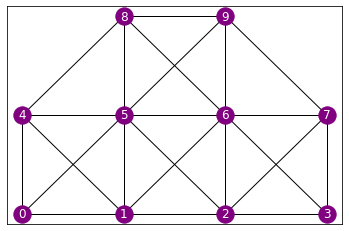

23

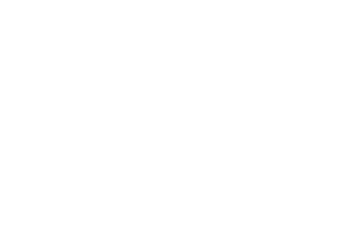

In [22]:
predicted_passes(442, plot=True)

Above we can see an example of our final function predicted passes. It takes a formation and assigns each player a coordinate. Then it creates connections of the players, and returns the total number of possible passes if the players remained static and had a short range. In the case of a 4-3-3 formation, we get 23 connections/possible passes. Please note that there is no double counting for the lines. 

The reason to leave long passes out of the networkX is because most of the passes performed in a match are short passes. A good improvement for future models would be to include long passes as well.

## Data Arrangement: Adding NetworkX 

Now that we have the data and our NetworkX function to categorize formations, we are going to proceed to add this function to out main dataframe. We officially have all the data we need!

In [32]:
# Create New Column with NetworkX Function
predict_passes_home = complete_dataset.agg({"Home Formation":[predicted_passes]})
predict_passes_away = complete_dataset.agg({"Away Formation":[predicted_passes]})

# Concatenate DataFrames
complete_dataset_pred = pd.concat([complete_dataset, predict_passes_home, predict_passes_away], axis=1)

# Rename Columns
complete_dataset_pred = complete_dataset_pred.rename(columns={('Home Formation', 'predicted_passes'): "Predicted Passes Home",
                                                                ('Away Formation', 'predicted_passes'): "Predicted Passes Away"
                                                               })

complete_dataset_pred

,Match ID,Home ID,Away ID,Home Name,Away Name,Home Formation,Away Formation,Home Goals,Away Goals,Home Goals Conceded,Away Goals Conceded,Home Passes,Away Passes,Red Cards Home,Red Cards Away,Home Pass Quality,Away Pass Quality,Predicted Passes Home,Predicted Passes Away
0,38678,131,11,Brighton,Man City,451.0,4411.0,1.0,4.0,4.0,1.0,245.0,796.0,0.0,0.0,0.75,0.95,18,19
1,38659,43,11,Burnley,Man City,442.0,433.0,0.0,1.0,1.0,0.0,263.0,608.0,0.0,0.0,0.85,0.95,23,20
2,38640,6,11,Crystal Palace,Man City,451.0,4231.0,1.0,3.0,3.0,1.0,274.0,721.0,0.0,0.0,0.75,0.95,18,19
3,38623,34,11,Fulham,Man City,541.0,433.0,0.0,2.0,2.0,0.0,359.0,679.0,0.0,0.0,0.65,0.95,17,20
4,38492,26,11,Leicester,Man City,433.0,433.0,2.0,1.0,1.0,2.0,320.0,613.0,0.0,1.0,0.85,0.95,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,38516,25,131,West Ham,Brighton,442.0,451.0,2.0,2.0,2.0,2.0,494.0,410.0,0.0,0.0,0.75,0.75,23,18
376,38657,38,131,Wolves,Brighton,352.0,433.0,0.0,0.0,0.0,0.0,615.0,297.0,0.0,0.0,0.65,0.75,20,20
377,38419,46,131,Cardiff,Brighton,4141.0,4411.0,2.0,1.0,1.0,2.0,472.0,315.0,0.0,1.0,0.65,0.75,12,19
378,38395,23,131,Newcastle,Brighton,4411.0,4411.0,0.0,1.0,1.0,0.0,504.0,247.0,0.0,0.0,0.85,0.75,19,19


## Descriptive Analysis

In this section, we are going to run some descriptive analysis to see the distribution of our data by formation and simple averages related to passes, goals scored, and goals conceded. 

##### Frequency of Formations

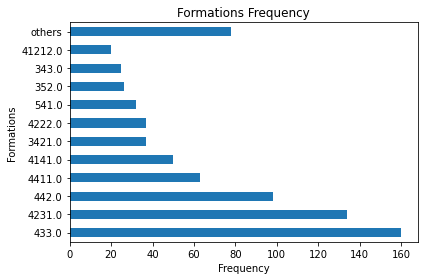

In [211]:
by_formation_home = complete_dataset_pred.groupby("Home Formation")["Home Formation"].agg("count")
by_formation_away = complete_dataset_pred.groupby("Away Formation")["Away Formation"].agg("count")

by_formation = pd.DataFrame(pd.concat([by_formation_home, by_formation_away], axis=1))
by_formation = by_formation.loc[:, ["Home Formation", "Away Formation"]].sum(axis=1)
by_formation = by_formation.sort_values(ascending=False)

top_10_formations = by_formation.iloc[0:11]
top_10_formations = pd.concat([top_10_formations, pd.DataFrame(data=[760 - top_10_formations.sum()], index=["others"])], axis=0)

fig, ax = plt.subplots()
top_10_formations.plot(kind="barh", legend=False, ax=ax)
#ax.axvline(by_formation.mean(), color="k", linestyle='--')
ax.set_title("Formations Frequency")
ax.set_ylabel("Formations")
ax.set_xlabel("Frequency")
fig.tight_layout()

##### Droping Red Cards

In [237]:
complete_dataset_nored = complete_dataset_pred[complete_dataset_pred["Red Cards Home"]==0]
complete_dataset_nored = complete_dataset_pred[complete_dataset_pred["Red Cards Away"]==0]

complete_dataset_nored

,Match ID,Home ID,Away ID,Home Name,Away Name,Home Formation,Away Formation,Home Goals,Away Goals,Home Goals Conceded,Away Goals Conceded,Home Passes,Away Passes,Red Cards Home,Red Cards Away,Home Pass Quality,Away Pass Quality,Predicted Passes Home,Predicted Passes Away
0,38678,131,11,Brighton,Man City,451.0,4411.0,1.0,4.0,4.0,1.0,245.0,796.0,0.0,0.0,0.75,0.95,18,19
1,38659,43,11,Burnley,Man City,442.0,433.0,0.0,1.0,1.0,0.0,263.0,608.0,0.0,0.0,0.85,0.95,23,20
2,38640,6,11,Crystal Palace,Man City,451.0,4231.0,1.0,3.0,3.0,1.0,274.0,721.0,0.0,0.0,0.75,0.95,18,19
3,38623,34,11,Fulham,Man City,541.0,433.0,0.0,2.0,2.0,0.0,359.0,679.0,0.0,0.0,0.65,0.95,17,20
5,38383,10,11,Liverpool,Man City,433.0,4231.0,0.0,0.0,0.0,0.0,515.0,528.0,0.0,0.0,0.95,0.95,20,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,38668,1,131,Arsenal,Brighton,4312.0,451.0,1.0,1.0,1.0,1.0,564.0,235.0,0.0,0.0,0.85,0.75,17,18
375,38516,25,131,West Ham,Brighton,442.0,451.0,2.0,2.0,2.0,2.0,494.0,410.0,0.0,0.0,0.75,0.75,23,18
376,38657,38,131,Wolves,Brighton,352.0,433.0,0.0,0.0,0.0,0.0,615.0,297.0,0.0,0.0,0.65,0.75,20,20
378,38395,23,131,Newcastle,Brighton,4411.0,4411.0,0.0,1.0,1.0,0.0,504.0,247.0,0.0,0.0,0.85,0.75,19,19


##### Formations and Number of Passes

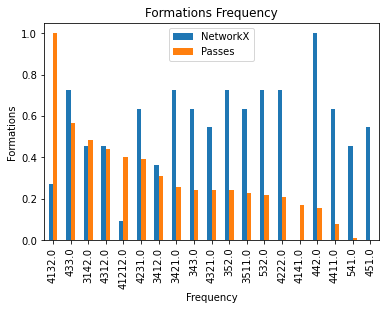

In [297]:
formation_passes_home = pd.DataFrame(complete_dataset_nored.loc[:,["Home Formation","Home Passes"]]).rename(
    columns={"Home Formation": "Formation",
             "Home Passes": "Passes"
            })
formation_passes_away = pd.DataFrame(complete_dataset_nored.loc[:,["Away Formation","Away Passes"]]).rename(
    columns={"Away Formation": "Formation",
             "Away Passes": "Passes"
            })

by_formation_passes = pd.DataFrame(pd.concat([formation_passes_home, formation_passes_away], axis=0, ignore_index=True))
by_formation_passes = by_formation_passes.groupby("Formation")["Passes"].agg("mean")


all_prem_formations = pd.DataFrame(list(by_formation_passes.index))
pred_prem_formations = all_prem_formations.agg({0:[predicted_passes]})
prem_formation = pd.concat([all_prem_formations, pred_prem_formations], axis=1).rename(
    columns={0: "Formation",
             (0, "predicted_passes"): "NetworkX"
            }).set_index("Formation")

pred_all_formations = prem_formation.join(by_formation_passes).sort_values(by="Passes", ascending=False)

normalize_passes = (pred_all_formations-pred_all_formations.min())/(pred_all_formations.max()-pred_all_formations.min())

normalize_passes

ax = normalize_passes.plot(kind="bar")
ax.set_title("Formations Frequency")
ax.set_ylabel("Formations")
ax.set_xlabel("Frequency")
fig.tight_layout()

##### Formation and Goals Scored

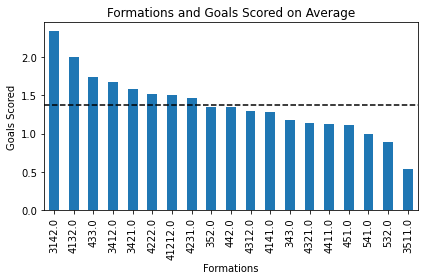

In [303]:
formation_passes_home = pd.DataFrame(complete_dataset_nored.loc[:,["Home Formation","Home Goals"]]).rename(
    columns={"Home Formation": "Formation",
             "Home Goals": "Goals"
            })
formation_passes_away = pd.DataFrame(complete_dataset_nored.loc[:,["Away Formation","Away Goals"]]).rename(
    columns={"Away Formation": "Formation",
             "Away Goals": "Goals"
            })

by_formation_goals = pd.DataFrame(pd.concat([formation_passes_home, formation_passes_away], axis=0, ignore_index=True))
by_formation_goals = by_formation_goals.groupby("Formation")["Goals"].agg("mean").sort_values(ascending=False)

fig, ax1 = plt.subplots()
by_formation_goals.plot(kind="bar", legend=False, ax=ax1)
ax1.axhline(by_formation_goals.mean(), color="k", linestyle='--')
ax1.set_title("Formations and Goals Scored on Average")
ax1.set_ylabel("Goals Scored")
ax1.set_xlabel("Formations")
fig.tight_layout()

Explanation:

##### Formations and Goals Conceded

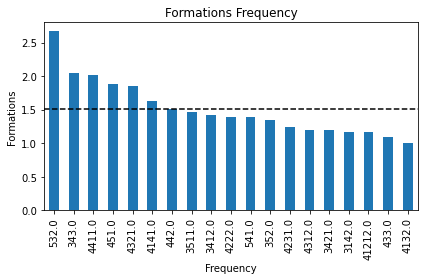

In [299]:
formation_passes_home = pd.DataFrame(complete_dataset_nored.loc[:,["Home Formation","Home Goals Conceded"]]).rename(
    columns={"Home Formation": "Formation",
             "Home Goals Conceded": "Goals Conceded"
            })
formation_passes_away = pd.DataFrame(complete_dataset_nored.loc[:,["Away Formation","Away Goals Conceded"]]).rename(
    columns={"Away Formation": "Formation",
             "Away Goals Conceded": "Goals Conceded"
            })

by_formation_conceded = pd.DataFrame(pd.concat([formation_passes_home, formation_passes_away], axis=0, ignore_index=True))
by_formation_conceded = by_formation_conceded.groupby("Formation")["Goals Conceded"].agg("mean").sort_values(ascending=False)

fig, ax1 = plt.subplots()
by_formation_conceded.plot(kind="bar", legend=False, ax=ax1)
ax1.axhline(by_formation_conceded.mean(), color="k", linestyle='--')
ax1.set_title("Formations Frequency")
ax1.set_ylabel("Formations")
ax1.set_xlabel("Frequency")
fig.tight_layout()

## Predictive Analysis

##### Regressions

Fit model: passes = 0.3337 + 0.0791 pass_prediction


23.50131027439049

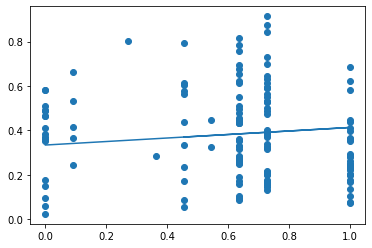

In [350]:
from sklearn.model_selection import train_test_split

formation_passes_home = pd.DataFrame(complete_dataset_nored.loc[:,["Home Formation","Home Passes", "Predicted Passes Home", 
                                                                   "Home Pass Quality"]]).rename(columns={
                                                                    "Home Formation": "Formation",
                                                                    "Home Passes": "Passes",
                                                                    "Predicted Passes Home": "Predicted Passes",
                                                                    "Home Pass Quality": "Pass Quality"
                                                                    })
formation_passes_away = pd.DataFrame(complete_dataset_nored.loc[:,["Away Formation","Away Passes", "Predicted Passes Away", 
                                                                   "Away Pass Quality"]]).rename(columns={
                                                                    "Away Formation": "Formation",
                                                                    "Away Passes": "Passes",
                                                                    "Predicted Passes Away": "Predicted Passes",
                                                                    "Away Pass Quality": "Pass Quality"
                                                                    })

reg_1 = pd.DataFrame(pd.concat([formation_passes_home, formation_passes_away], axis=0, ignore_index=True))

normalize_reg_1 = (reg_1-reg_1.min())/(reg_1.max()-reg_1.min())

predicted_train, predicted_test, passes_train, passes_test = train_test_split(
                                                             normalize_reg_1["Predicted Passes"].values, 
                                                             normalize_reg_1["Passes"].values, 
                                                             test_size=0.20)
# construct the model instance
pass_prediction = linear_model.LinearRegression()

# fit the model
pass_prediction.fit(predicted_train.reshape(-1, 1), passes_train.reshape(-1, 1))

# print the coefficients
beta_0 = pass_prediction.intercept_
beta_1 = pass_prediction.coef_[0]

print(f"Fit model: passes = {beta_0[0]:.4f} + {beta_1[0]:.4f} pass_prediction")

a = pass_prediction.predict(predicted_test.reshape(-1, 1))

plt.plot(predicted_test, a)
plt.scatter(predicted_test, passes_test)

absolute_error = np.sum(abs(a - passes_test)) / passes_test.shape[0]

absolute_error

Fit model: passes = 0.1936 + 0.3717 pass_prediction


23.50608686249858

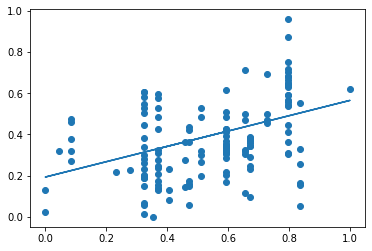

In [357]:
pass_weighted_quality = reg_1["Predicted Passes"] * reg_1["Pass Quality"]
pass_weighted_quality = pd.DataFrame(pass_weighted_quality).rename(columns={0: "Weighted Predicted Pass"})

reg_2 = pd.concat([reg_1, pass_weighted_quality], axis=1)

normalize_reg_2 = (reg_2-reg_2.min())/(reg_2.max()-reg_2.min())

predicted_train, predicted_test, passes_train, passes_test = train_test_split(
                                                             normalize_reg_2["Weighted Predicted Pass"].values, 
                                                             normalize_reg_2["Passes"].values, 
                                                             test_size=0.20)
# construct the model instance
pass_prediction = linear_model.LinearRegression()

# fit the model
pass_prediction.fit(predicted_train.reshape(-1, 1), passes_train.reshape(-1, 1))

# print the coefficients
beta_0 = pass_prediction.intercept_
beta_1 = pass_prediction.coef_[0]

print(f"Fit model: passes = {beta_0[0]:.4f} + {beta_1[0]:.4f} pass_prediction")

a = pass_prediction.predict(predicted_test.reshape(-1, 1))

plt.plot(predicted_test, a)
plt.scatter(predicted_test, passes_test)

absolute_error = np.sum(abs(a - passes_test)) / passes_test.shape[0]

absolute_error

Fit model: passes = 0.9622 + 0.2703 pass_prediction


44.80353176287407

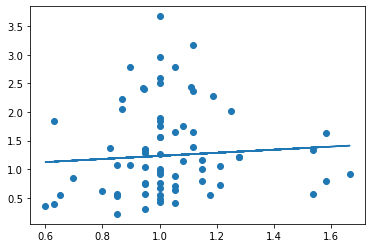

In [366]:
pass_ratio = complete_dataset_nored["Home Passes"] / complete_dataset_nored["Away Passes"]
pass_ratio = pd.DataFrame(pass_ratio).rename(columns={0: "Home/Away Pass Ratio"})

pred_pass_ratio = complete_dataset_nored["Predicted Passes Home"] / complete_dataset_nored["Predicted Passes Away"]
pred_pass_ratio = pd.DataFrame(pred_pass_ratio).rename(columns={0: "Home/Away Predicted Pass Ratio"})

reg_3 = pd.concat([pred_pass_ratio, pass_ratio], axis=1)

predicted_train, predicted_test, passes_train, passes_test = train_test_split(
                                                             reg_3["Home/Away Predicted Pass Ratio"].values, 
                                                             reg_3["Home/Away Pass Ratio"].values, 
                                                             test_size=0.20)
# construct the model instance
pass_prediction = linear_model.LinearRegression()

# fit the model
pass_prediction.fit(predicted_train.reshape(-1, 1), passes_train.reshape(-1, 1))

# print the coefficients
beta_0 = pass_prediction.intercept_
beta_1 = pass_prediction.coef_[0]

print(f"Fit model: passes = {beta_0[0]:.4f} + {beta_1[0]:.4f} pass_prediction")

a = pass_prediction.predict(predicted_test.reshape(-1, 1))

plt.plot(predicted_test, a)
plt.scatter(predicted_test, passes_test)

absolute_error = np.sum(abs(a - passes_test)) / passes_test.shape[0]

absolute_error

Fit model: passes = 0.2366 + 0.9900 pass_prediction


45.073513187137095

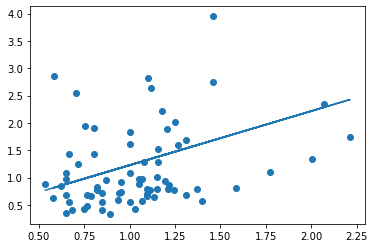

In [368]:
pass_ratio = complete_dataset_nored["Home Passes"]/complete_dataset_nored["Away Passes"]
pass_ratio = pd.DataFrame(pass_ratio).rename(columns={0: "Home/Away Pass Ratio"})

pred_pass_ratio = (complete_dataset_nored["Predicted Passes Home"] *complete_dataset_nored["Home Pass Quality"])/(complete_dataset_nored["Predicted Passes Away"]*complete_dataset_nored["Away Pass Quality"])
pred_pass_ratio = pd.DataFrame(pred_pass_ratio).rename(columns={0: "Home/Away Predicted Pass Ratio"})

reg_3 = pd.concat([pred_pass_ratio, pass_ratio], axis=1)

predicted_train, predicted_test, passes_train, passes_test = train_test_split(
                                                             reg_3["Home/Away Predicted Pass Ratio"].values, 
                                                             reg_3["Home/Away Pass Ratio"].values, 
                                                             test_size=0.20)
# construct the model instance
pass_prediction = linear_model.LinearRegression()

# fit the model
pass_prediction.fit(predicted_train.reshape(-1, 1), passes_train.reshape(-1, 1))

# print the coefficients
beta_0 = pass_prediction.intercept_
beta_1 = pass_prediction.coef_[0]

print(f"Fit model: passes = {beta_0[0]:.4f} + {beta_1[0]:.4f} pass_prediction")

a = pass_prediction.predict(predicted_test.reshape(-1, 1))

plt.plot(predicted_test, a)
plt.scatter(predicted_test, passes_test)

absolute_error = np.sum(abs(a - passes_test)) / passes_test.shape[0]

absolute_error